In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import random

import synchrony.PlottingTools as plottingTools
from synchrony.ParameterSet import ParameterSet
import synchrony.DataStorage as dataStorage
import synchrony.DataAnalysis as dataAnalysis
import synchrony.MakeDataframe as makeDataframe
from synchrony import mainClass

In [2]:
file_path_input_params_json = '../input_params.json'
input_param_dict = mainClass.extract_variables_from_input_params_json(file_path_input_params_json)
root_path = input_param_dict["DATA_FOLDER_PATH"]
simulation_location = 'Paper/Fig_A05'#'Thesis/X_Appendix/A3_growth_rate' '/home/berger/Data/Synchrony/NotebookData/Tests/Fraction_synchronised_hill/LD_model/new_params'
file_path = os.path.join(root_path, simulation_location)
print('file_path', file_path)
parameter_path = os.path.join(file_path, 'parameter_set.csv')
print('parameter_path', parameter_path)

file_path /home/berger/Data/Synchrony/Paper/Fig_A05
parameter_path /home/berger/Data/Synchrony/Paper/Fig_A05/parameter_set.csv


In [3]:
pinkish_red = (247 / 255, 109 / 255, 109 / 255)
green = (0 / 255, 133 / 255, 86 / 255)
dark_blue = (36 / 255, 49 / 255, 94 / 255)
light_blue = (168 / 255, 209 / 255, 231 / 255)
blue = (55 / 255, 71 / 255, 133 / 255)
yellow = (247 / 255, 233 / 255, 160 / 255)

# Make the data frame

In [4]:
data_frame = makeDataframe.make_dataframe(file_path)
# data_frame = makeDataframe.add_average_values_to_df(data_frame)
# data_frame

['/home/berger/Data/Synchrony/Paper/Fig_A05/fig_A3.pdf',
 '/home/berger/Data/Synchrony/Paper/Fig_A05/8427_A1_vary_growth_rate']


# Calculate degree of synchronisation

In [6]:
def fraction_initiated_origins_per_cascade(initiation_times, n_ori_init, row):
    cascade_event_list = []
    new_cluster = 1
    n_ori = 1
    n_steps_extra = 800 # time added to delay time for maximal duration of one cascade
    for indx in range(0, initiation_times.size):
#         print(indx)
        if new_cluster == 1:
            count = 1
            t_max = initiation_times[indx] + row.t_doubling_datA + n_steps_extra * row.time_step
            n_ori = n_ori_init[indx]
            new_cluster = 0
        else:
            if initiation_times[indx] <= t_max:
                count = count + 1
            else:
#                 if row.site_datA == 0.24:
#                     print('fraction of origins initiated:', count, n_ori, count/ n_ori)
                cascade_event_list.append(count/ n_ori)
                count = 1
                t_max = initiation_times[indx] +  row.t_doubling_datA + n_steps_extra * row.time_step
                n_ori = n_ori_init[indx]
#     print(row.sub_simu_name, cascade_event_list)   
#     print('init times:', np.array(initiation_times))
    return cascade_event_list

def mean_and_var_of_fraction_initiated_origins_per_cascade(row):
    data_frame_init = pd.read_hdf(row.path_dataset, key='dataset_init_events')
    initiation_times = data_frame_init['t_init']
    n_ori_init = data_frame_init['n_ori_init']
    fract_init_origins_per_cascade = fraction_initiated_origins_per_cascade(initiation_times, n_ori_init,  row)
    return np.mean(fract_init_origins_per_cascade), np.var(fract_init_origins_per_cascade)

def degree_synch(row):
    degree_synch, variance_synch = mean_and_var_of_fraction_initiated_origins_per_cascade(row)
    return degree_synch

def variance_synch(row):
    degree_synch, variance_synch = mean_and_var_of_fraction_initiated_origins_per_cascade(row)
    return variance_synch


data_frame.loc[:, 'degree_synch'] = data_frame.apply(lambda row: degree_synch(row), axis = 1)
data_frame.loc[:, 'variance_synch'] = data_frame.apply(lambda row: variance_synch(row), axis = 1)

# Comparison to theory

In [7]:
def integrand_prob_two_events(t1, growth_rate_, v_init_, V_b_, n_, firing_rate_0_, delta_t):
    vol_t1 = V_b_ * np.exp(growth_rate_ * t1)
    vol_t1_delay = V_b_ * np.exp(growth_rate_ * (t1+ delta_t))
    prefactor = 2 * firing_rate_0_ * vol_t1**n_/(vol_t1**n_ + v_init_**n_)
    exponential = np.exp(-np.log((vol_t1_delay**n_ + v_init_**n_)/(V_b_**n_ + v_init_**n_))/(growth_rate_ * n_)*2* firing_rate_0_)
    return prefactor * exponential

def integrate_two_events(growth_rate, v_init, V_b, effective_hill_coeff, firing_rate_0, delta_t):
    integrate.quad(lambda x: integrand_prob_two_events(x,
                                                   growth_rate, 
                                                   v_init, 
                                                   V_b, 
                                                   effective_hill_coeff, 
                                                   firing_rate_0, delta_t) , 0,  5)[0]
    
def calculate_fraction_from_prob(row):
    return row.theoretical_prediction + (1-row.theoretical_prediction)* 0.5

def calculate_fraction_from_prob_simu(row):
    return row.simu_prob + (1-row.simu_prob)* 0.5

In [8]:
data_frame.loc[:, 'theoretical_prediction'] = data_frame.apply(lambda row: 1-integrate.quad(lambda x: integrand_prob_two_events(x,
                                                                                               row.rate_growth,
                                                                                               row.v_init_th,
                                                                                               0.01,
                                                                                               row.hill_activation_potential * row.hill_origin_opening /2, 
                                                                                               row.origin_firing_rate,
                                                                                               row.t_doubling_datA) , 0,  13)[0], axis = 1)
# data_frame.theoretical_prediction

/home/berger/.virtualenvs/synchrony_project/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/home/berger/.virtualenvs/synchrony_project/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/home/berger/.virtualenvs/synchrony_project/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in double_scalars
  """
/home/berger/.virtualenvs/synchrony_project/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/home/berger/.virtualenvs/synchrony_project/lib/python3.7/site-packages/ipykernel_launcher.py:7: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the d

# Comparison to simple simulation

In [9]:
def calculate_approx_opening_prob_of_time(t, rate_growth, v_birth, hill_coeff_eff, crit_vol):
    vol= v_birth * np.exp(rate_growth*t)
    return vol**hill_coeff_eff/(vol**hill_coeff_eff+ crit_vol**hill_coeff_eff)

def calculate_whether_initiate(rate, time_step):
    prob = rate * time_step
    random_number = random.random()
    return prob >= random_number

def make_list_intervals(t_max, time_step, rate_growth, v_birth, hill_coeff_eff, crit_vol, firing_rate_0):
    n_simu = 1000
    list_t_init_tupel = []
    time = np.arange(0, t_max, time_step)
#     print(time)
    approx_opening_probability_of_time = calculate_approx_opening_prob_of_time(time, rate_growth, v_birth, hill_coeff_eff, crit_vol)
    for simu_i in range(0, n_simu):
        init_events = []
        n_events = 0
        for n_step in range(1, time.size): # start at one because 0 is the initial condition
            if calculate_whether_initiate(firing_rate_0 * approx_opening_probability_of_time[n_step], time_step):
                init_events.append(time[n_step])
#                 print('init event happened')
                n_events = n_events + 1
                if n_events >=2:
                    break
        list_t_init_tupel.append(init_events)
    delta_t = [item[1]-item[0] for item in list_t_init_tupel]
    return delta_t

def calculate_fraction_intervals_smaller_than_x(intervalls, x):
    intervalls = np.array(intervalls)
    smaller = intervalls[intervalls<x]
    return smaller.size / intervalls.size



In [10]:
list_of_hill_coeffs = data_frame['hill_origin_opening'].unique()
cache_delta_t = {}
for item in list_of_hill_coeffs:
    data_frame_item = data_frame.loc[data_frame['hill_origin_opening']==item]
#     print(data_frame_item['time_step'].iloc[0])
    delta_t = make_list_intervals(10, 
                                  data_frame_item['time_step'].iloc[0], 
                                  data_frame_item['rate_growth'].iloc[0],
                                  0.5,
                                  data_frame_item['hill_origin_opening'].iloc[0] * data_frame_item['hill_activation_potential'].iloc[0] /2,
                                  data_frame_item['v_init_th'].iloc[0],
                                  data_frame_item['origin_firing_rate'].iloc[0]
                                 )
#     print(delta_t)
    cache_delta_t[item]= delta_t

In [11]:

data_frame.loc[:, 'simu_prob'] = data_frame.apply(lambda row: calculate_fraction_intervals_smaller_than_x(cache_delta_t[row.hill_origin_opening], row.t_doubling_datA), axis = 1)    

In [12]:

data_frame.loc[:, 'th_deg_synch'] = data_frame.apply(lambda row: calculate_fraction_from_prob(row), axis = 1)

data_frame.loc[:, 'simu_deg_synch'] = data_frame.apply(lambda row: calculate_fraction_from_prob_simu(row), axis = 1)

# Make Legend

In [13]:
def make_hill_coeff_legend(hill_activation_potential, hill_origin_opening):
    return r'$n_{{\rm eff}}={}$'.format(int(hill_activation_potential*hill_origin_opening/2))

def make_deactivation_rate_legend(deactivation_rate_datA):
    return r'$\beta_{{datA}}={}$ min$^{{-1}}$'.format(int(deactivation_rate_datA/60))

def make_mich_menten_legend(michaelis_const_deact):
    return r'$K_{{D}}={} \, \mu$m$^{{-3}}$'.format(int(michaelis_const_deact))

def make_doubling_time_legend(doubling_rate):
    return r'$\tau_{{d}}={}$ min'.format(int(np.round(60/doubling_rate,0)))
    
data_frame.loc[:, 'Hill coefficients:'] = data_frame.apply(lambda row: make_hill_coeff_legend(row.hill_activation_potential, row.hill_origin_opening), axis = 1)
  
data_frame.loc[:, 'deactivation rate:'] = data_frame.apply(lambda row: make_deactivation_rate_legend(row.deactivation_rate_datA), axis = 1)

data_frame.loc[:, 'Dissociation constant:'] = data_frame.apply(lambda row: make_mich_menten_legend(row.michaelis_const_deact), axis = 1)

data_frame.loc[:, 'Doubling time:'] = data_frame.apply(lambda row: make_doubling_time_legend(row.doubling_rate), axis = 1)

# Plot fraction that is synchronised

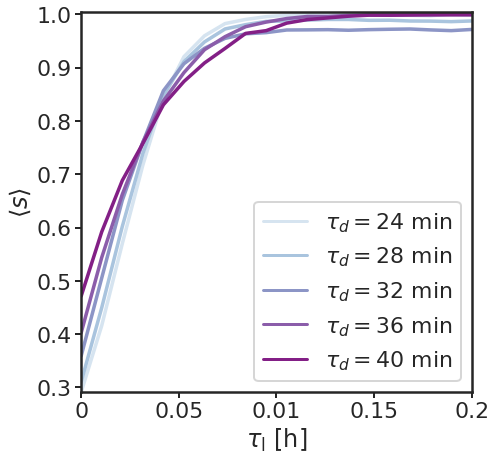

In [14]:
sns.set(style="ticks")
sns.set_context("poster")
palette='BuPu'

data_frame_sorted = data_frame.sort_values(by=["hill_activation_potential"], ascending=True)
fig, ax = plt.subplots(figsize=(7,7))
ax.set(xlabel=r'$\tau_{\rm l}$ [h]', ylabel=r'$\langle s \rangle$')
sns.lineplot(
    x='t_doubling_datA', 
    y='degree_synch',
    data=data_frame_sorted.sort_values(by=["doubling_rate"], ascending=False),
    hue='Doubling time:',
#     hue='deactivation rate:',
#     dashes=[(4, 1), ''],
#     markers=True,
    palette= palette,
#     style='theoretical_prediction',
    linewidth = 3.5,
    ax=ax
);

# sns.lineplot(
#     x='t_doubling_datA', 
#     y='th_deg_synch',
#     data=data_frame_sorted.sort_values(by=["doubling_rate"], ascending=False),
#     hue='doubling_rate',
# #     hue='deactivation rate:',
#     linestyle="dashed",
#     markers=True,
#     palette= palette,
# #     style='theoretical_prediction',
#     linewidth = 3.5,
#     legend = False,
#     ax=ax
# );

ax.margins(0)

# ax.axhline(y=1, color='grey', linestyle='dotted')
# ax.axhline(y=0.5, color=green, linestyle='--')
# ax.axvline(x=(data_frame["period_blocked"][0]), color='grey', linestyle='dotted')
# ax.set(ylim=(0.5, 1))
ax.set_xticks([0,0.05, 0.1, 0.15, 0.2])
ax.set_xticklabels([r'0',r'0.05', r'0.01', r'0.15', r'0.2'])
ax.tick_params(direction='out', length=6, width=2, grid_alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
# ax.legend(bbox_to_anchor=(1, 1))
plt.savefig(file_path + '/fig_A3.pdf', format='pdf', bbox_inches='tight')